# Cross Validation of GateNet
In this example, we will cross-validate GateNet using the publicly available ND dataset consisting of 30 expert gated samples which were published during the [FlowCAP I challenge](https://www.nature.com/articles/nmeth.2365).

To rerun this notebook, the [FlowCAP data](http://flowcap.flowsite.org/codeanddata/FlowCAP-I.zip) has to be downloaded.

In [1]:
import sys; sys.path.append('..')
import numpy as np

from src.data.files import get_files_df
from src.data.utils import unique_labels
from src.train import HPARAMS
from src.cv import cv
from src.utils import set_seed

For deterministic results we can fix all seeds

In [2]:
set_seed(seed=0)

To rerun this notebook, you have to unzip the downloaded [FlowCAP data](http://flowcap.flowsite.org/codeanddata/FlowCAP-I.zip). Then you have to set 'flowcap_dir' to the path of your unzipped directory.

In [3]:
flowcap_dir = '/mnt/data-ssd/cyto/flowcap1'
fcs_dir = f'{flowcap_dir}/Data/FCM/fcs/NDD/FCS'
label_dir = f'{flowcap_dir}/Data/Labels/NDD'

The FCS filepaths (.fcs, .lmd or .LMD) and respective gating labels (.csv or .ftr) are loaded into a pandas DataFrame

In [4]:
df = get_files_df(fcs_dir, label_dir)
print(df.head())

                                                        fcs  \
0  /mnt/data-ssd/cyto/flowcap1/Data/FCM/fcs/NDD/FCS/001.fcs   
1  /mnt/data-ssd/cyto/flowcap1/Data/FCM/fcs/NDD/FCS/002.fcs   
2  /mnt/data-ssd/cyto/flowcap1/Data/FCM/fcs/NDD/FCS/003.fcs   
3  /mnt/data-ssd/cyto/flowcap1/Data/FCM/fcs/NDD/FCS/004.fcs   
4  /mnt/data-ssd/cyto/flowcap1/Data/FCM/fcs/NDD/FCS/005.fcs   

                                                labels  
0  /mnt/data-ssd/cyto/flowcap1/Data/Labels/NDD/001.csv  
1  /mnt/data-ssd/cyto/flowcap1/Data/Labels/NDD/002.csv  
2  /mnt/data-ssd/cyto/flowcap1/Data/Labels/NDD/003.csv  
3  /mnt/data-ssd/cyto/flowcap1/Data/Labels/NDD/004.csv  
4  /mnt/data-ssd/cyto/flowcap1/Data/Labels/NDD/005.csv  


Before the data can be loaded, we first have to specify a complete vocabulary of labels (i.e. cell types) which occur in the dataset (should print ['0', '1', '2', '3', '4', '5', '6', '7'])

In [5]:
vocab = unique_labels(label_dir, label_col := 0)
print(vocab)

['0', '1', '2', '3', '4', '5', '6', '7']


In [6]:
ds_kwargs = {'vocab': vocab, 'multiclass_col': label_col}

On top of that, the marker intensities have to be rescaled and normalised such that they resemble a normal distribution (mean 0 and standard deviation 1) as closely as possible.

Color marker intensities are typically normally distributed while forward and side scatter intensities often are distributed exponentially. Therefore, the scatter intensities (here 'FSC-A' and 'SSC-A') have to be rescaled using $log(x + 1)$ to yield normal distributions. Alongside the 'forward' transformation (here $log(x + 1)$) the respective, inverse 'backward' transformation (here $e^x - 1$) has to be specified

In [7]:
fcs_scaling = {'forward': {'FSC-A': lambda x: np.log(x + 1), 'SSC-A': lambda x: np.log(x + 1)},
               'backward': {'FSC-A': lambda x: np.exp(x) - 1, 'SSC-A': lambda x: np.exp(x) - 1}}

The distributions have to be normalized such that the mean is 0 and a standard deviation is 1. This is simply done by subtracting the current mean and dividing by the current standard deviation. For the ND dataset, (mean, standard deviation) of the rescaled markers are:

In [8]:
fcs_norm_stats = {'FSC-A': (12., .43), 'SSC-A': (11., .79), 'FITC-A': (1.8, 0.44), 'PerCP-Cy5-5-A': (0.96, 0.34),
                  'Pacific Blue-A': (1.6, 0.36), 'Pacifc Orange-A': (1.3, 0.25), 'QDot 605-A': (0.72, 0.34),
                  'APC-A': (1.1, 0.41), 'Alexa 700-A': (2.4, 0.5), 'PE-A': (1.4, 0.26),
                  'PE-Cy5-A': (2.4, 0.36), 'PE-Cy7-A': (2.2, 0.47)}

In [9]:
dl_kwargs = {'fcs_norm_stats': fcs_norm_stats, 'fcs_scaling': fcs_scaling}

Finally, the hyperparameters for the GateNet training are set

In [10]:
hparams = HPARAMS
print(hparams)

{'iters': 5000, 'iters_min': 50, 'epochs_max': 10, 'lr': 0.002, 'bs': 1024, 'gamma': 5, 'beta': 0.99, 'n_filter': (1024, 512, 256), 'n_filter_context': (64, 48), 'n_head_nodes': (32,), 'balance_ids': False, 'oversample_beta': 0.999, 'n_context_events': 1000}


For a quick test run (with lower performance), the number of iterations can be reduced. By default it is set to 5000.

In [11]:
# hparams.update({'iters': 100})

Five-fold cross-validation is done.

In [12]:
result = cv(df, hparams, ds_kwargs, dl_kwargs, folds=5, with_targs=True)
print(result.head())

       FSC-A      SSC-A    FITC-A  PerCP-Cy5-5-A  Pacific Blue-A  \
0  11.540473  10.790753  2.157689       0.579083        1.930591   
1  10.871103   9.989284  1.962930       0.401545        1.797101   
2  11.093181  10.688510  2.064609       0.281483        1.785131   
3  11.567129  12.020021  2.266574       1.119162        1.928758   
4  10.843714  10.350043  2.076122       0.328035        1.740867   

   Pacifc Orange-A  QDot 605-A     APC-A  Alexa 700-A      PE-A  ...  0  1  2  \
0         1.253792    0.842704  0.887293     1.839019  1.305078  ...  1  0  0   
1         1.227518    0.871632  1.043129     1.782810  1.151766  ...  1  0  0   
2         1.213261    0.635844  0.288231     1.856309  1.181292  ...  1  0  0   
3         1.275034    0.840032  1.035842     2.085839  1.334119  ...  0  0  1   
4         1.627157    0.956006  0.725581     1.928788  1.099105  ...  1  0  0   

   3  4  5  6  7                                                   id  fold  
0  0  0  0  0  0  /mnt/dat

The 'result' of the cross validation is a DataFrame with marker intensities + true labels + predicted labels + id (filename) + fold across all validation folds. In this case, this are too many columns to display. So we split it up into the marker intensities...

In [13]:
print(result.iloc[:, :12].head())

       FSC-A      SSC-A    FITC-A  PerCP-Cy5-5-A  Pacific Blue-A  \
0  11.540473  10.790753  2.157689       0.579083        1.930591   
1  10.871103   9.989284  1.962930       0.401545        1.797101   
2  11.093181  10.688510  2.064609       0.281483        1.785131   
3  11.567129  12.020021  2.266574       1.119162        1.928758   
4  10.843714  10.350043  2.076122       0.328035        1.740867   

   Pacifc Orange-A  QDot 605-A     APC-A  Alexa 700-A      PE-A  PE-Cy5-A  \
0         1.253792    0.842704  0.887293     1.839019  1.305078  2.300368   
1         1.227518    0.871632  1.043129     1.782810  1.151766  2.834283   
2         1.213261    0.635844  0.288231     1.856309  1.181292  3.147278   
3         1.275034    0.840032  1.035842     2.085839  1.334119  2.058220   
4         1.627157    0.956006  0.725581     1.928788  1.099105  2.853909   

   PE-Cy7-A  
0  1.809408  
1  2.883132  
2  2.747585  
3  1.577168  
4  3.004694  


...and the predicted labels, true labels, id (filename) and fold across all validation folds

In [14]:
print(result.iloc[:, 12:].head())

     0_pred    1_pred    2_pred    3_pred    4_pred    5_pred    6_pred  \
0  0.000527  0.000037  0.000563  0.994218  0.000398  0.000058  0.000234   
1  0.000428  0.000088  0.000003  0.000118  0.000062  0.000055  0.997056   
2  0.999785  0.000050  0.000088  0.000004  0.000058  0.000007  0.000001   
3  0.040541  0.000211  0.955730  0.000080  0.000080  0.000241  0.001102   
4  0.000064  0.000260  0.000002  0.000505  0.000069  0.000253  0.994033   

     7_pred  0  1  2  3  4  5  6  7  \
0  0.003965  1  0  0  0  0  0  0  0   
1  0.002190  1  0  0  0  0  0  0  0   
2  0.000008  1  0  0  0  0  0  0  0   
3  0.002014  0  0  1  0  0  0  0  0   
4  0.004815  1  0  0  0  0  0  0  0   

                                                    id  fold  
0  /mnt/data-ssd/cyto/flowcap1/Data/Labels/NDD/003.csv     0  
1  /mnt/data-ssd/cyto/flowcap1/Data/Labels/NDD/003.csv     0  
2  /mnt/data-ssd/cyto/flowcap1/Data/Labels/NDD/003.csv     0  
3  /mnt/data-ssd/cyto/flowcap1/Data/Labels/NDD/003.csv     0  

## Visualize results

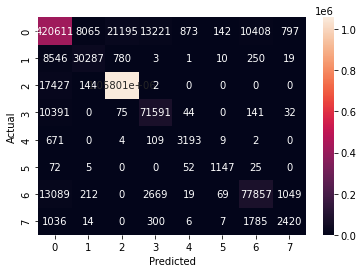

In [17]:
from src.eval import plot_confusion_matrix, cv_metrics_table

plot_confusion_matrix(result)

With 'cv_metrics_table' the metrics accuracy, balanced accuracy, weighted and unweighted F1 score of the results can be calculated. The rows "mean" and "std" show the average and standard deviation of the metrics across folds.

In [18]:
cv_metrics_table(result)

,ACC,BACC,F1_weighted,F1_macro
0,0.939407,0.790963,0.939076,0.813443
1,0.941879,0.795431,0.941803,0.804426
2,0.917142,0.801626,0.917121,0.762276
3,0.941038,0.804906,0.940335,0.831395
4,0.942321,0.831302,0.942154,0.821575
mean,0.936358,0.804845,0.936098,0.806623
std,0.009659,0.014083,0.009552,0.023897
